In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.reconstruction import MemAutoEncoder
from src.trainer.ids import MemAEIDSTrainer, plot_metrics
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results
import itertools as it

In [2]:
# Setup base folder structure
dataset_path = "../data/IDS2017/ids2017.csv"
export_path = "memae_experiments"
checkpoint_path = export_path + "/checkpoints"
if not os.path.exists(export_path):
    os.mkdir(export_path)
    os.mkdir(checkpoint_path)

# General arguments
batch_size = 1024
device = "cuda"
lr = 1e-4
n_epochs = 200

# Model specific arguments
mem_dim = 50
latent_dim = 1
shrink_thres = 0.0025
n_layers = 4
compression_factor = 2
act_fn = "relu"
alpha = 2e-4

print("arguments set")

arguments set


In [3]:
dataset = IDS2017Dataset(path=dataset_path)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

data loaded


## Hyperparameter search

In [10]:
batch_size = [64, 512, 1024]
mem_dims = [50, 100, 150]
latent_dim = [5, 10, dataset.in_features // 6]

for bs, md, ld in it.product(batch_size, mem_dims, latent_dim):
    n_layers = 4 if ld <= 10 else 3
    model = MemAutoEncoder(
        in_features=dataset.in_features,
        n_instances=dataset.n_instances,
        device=device,
        mem_dim=md,
        latent_dim=ld,
        shrink_thres=shrink_thres,
        n_layers=n_layers,
        compression_factor=2,
        alpha=2e-4,
        act_fn="relu",
    )
    trainer = MemAEIDSTrainer(
        train_ldr=train_ldr,
        test_ldr=test_ldr,
        device=device,
        model=model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=n_epochs,
        ckpt_fname=os.path.join(checkpoint_path, "memae"),
        run_test_validation=True

    )
print("MemAE model and trainer ready")
print(model)

MemAE model and trainer ready
MemAutoEncoder(
  (act_fn): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=65, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=65, bias=True)
  )
  (mem_rep): MemoryUnit()
)


## MemAE Training

In [4]:
model = MemAutoEncoder(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    mem_dim=mem_dim,
    latent_dim=latent_dim,
    shrink_thres=shrink_thres,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn="relu",
    alpha=alpha
)
trainer = MemAEIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    device=device,
    model=model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_fname=os.path.join(checkpoint_path, "memae"),
    run_test_validation=True
)
print("MemAE model and trainer ready")
print(model)

MemAE model and trainer ready
MemAutoEncoder(
  (act_fn): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=65, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=65, bias=True)
  )
  (mem_rep): MemoryUnit()
)


  1%|          | 9/1110 [00:00<00:58, 18.90it/s, epoch=1, loss=0.141]

Started training


100%|██████████| 1110/1110 [00:14<00:00, 76.45it/s, epoch=200, loss=0.011]


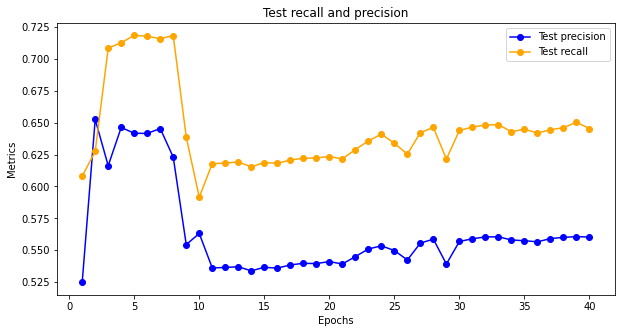

In [25]:
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
trainer.train(train_ldr)
plot_metrics(export_path, trainer.metric_values["test_precision"], trainer.metric_values["test_recall"])

In [27]:
test_precision = trainer.metric_values['test_precision']
np.argmax(test_precision), np.max(test_precision)

(1, 0.6525377899279073)

In [5]:
best_epoch = 7 * 5 + 1
best = export_path + "/checkpoints/memae_epoch={}.pt".format(best_epoch)
trainer, model = MemAEIDSTrainer.load_from_file(best, trainer, model)
trainer.n_epochs = best_epoch
y_test_true, test_scores, test_labels = trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=best_epoch, **model.get_params()),
    model_name="MemAE",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6230154594676991,
 'Recall': 0.718274953689009,
 'F1-Score': 0.6672625046853525,
 'AUPR': 0.720567635795567,
 'AUROC': 0.8472783048251309,
 'Thresh_star': 0.03125389665365219,
 'Quantile_star': 62.081617244691174}

In [6]:
misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
misclf_df = misclf_df.sort_values("Misclassified ratio", ascending=False)
misclf_df.to_csv(export_path + "/memae_misclassifications.csv")
misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
Web Attack,2180,2082,0.955046
Bot,1966,1852,0.942014
PortScan,158930,82059,0.516322
SSH-Patator,5897,2949,0.500085
FTP-Patator,7938,3824,0.481733
BENIGN,1136374,242366,0.213280
DDoS,128027,26747,0.208917
DoS,252658,37586,0.148762
Infiltration,36,3,0.083333
Heartbleed,11,0,0.000000


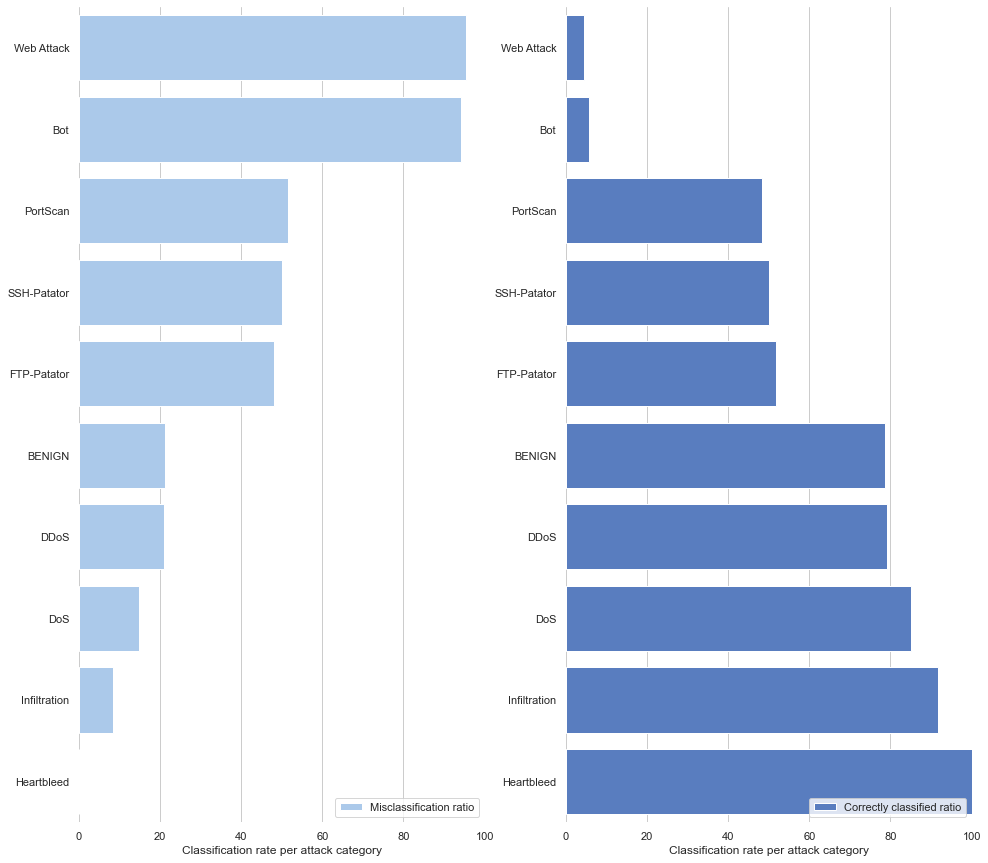

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axs = plt.subplots(figsize=(16, 15), ncols=2)

# Plot misclassification rates
sns.set_color_codes("pastel")
sns.barplot(
    x=misclf_df["Misclassified ratio"] * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Misclassification ratio",
    color="b",
    ax=axs[0]
)

# Plot correct classification rate
sns.set_color_codes("muted")
sns.barplot(
    x=(1-misclf_df["Misclassified ratio"]) * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Correctly classified ratio",
    color="b",
    ax=axs[1]
)

# Add a legend and informative axis label
for ax in axs:
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
sns.despine(left=True, bottom=True)